# Task
Project 19: News Popularity Dataset Analysis

1. Analyze the Kaggle News Popularity dataset (Jan–Apr 2022, 9100 NYT tweets). The dataset includes tweet IDs, retweets, replies, likes, timestamps, and bag_of_phrases.
2. Graph Construction & Analysis: NER Graph Construction: Use spaCy to extract named entities (person, organization, location) from bag_of_phrases. Connect tweets (nodes) sharing at least one entity. Plot histograms for entity counts by type.
3. Degree Analysis: Use NetworkX to plot degree distribution. Create a table for max, min, avg degree centrality, and average path length.
4. Centrality Metrics: Compute and plot betweenness and closeness centralities. Save scores. Analyze top nodes’ bag_of_phrases content.
5. Clustering: Calculate and save clustering coefficients. Plot histogram (10 bins) of their distribution.
6. Token Correlation: For Retweet, Reply, and Like counts, extract the top 10 tokens/entities. For the top and bottom 5 nodes by each metric, report the most frequent tokens/entities. Discuss correlations between content and popularity.
7. Community Detection: Apply the Louvain algorithm to detect communities. Visualize with Gephi. Generate and plot word clouds for the three largest communities using concatenated bag_of_phrases.
8. Attribute Correlation: Compute Pearson correlation + p-value between Retweet and Like, and Reply and Like counts, counts (Retweet, Reply, Like) and token count in bag_of_phrases.
9. Erdos Number Simulation: Use the highest-degree node as “Erdos.” Calculate other nodes' Erdos numbers. Save and plot the distribution.
10. Literature Review: Summarize relevant research to contextualize findings (e.g., social network analysis, tweet virality, named entity influence on engagement).

## Data loading

Minimum timestamp in filtered data: 2022-01-01 00:00:16+00:00
194


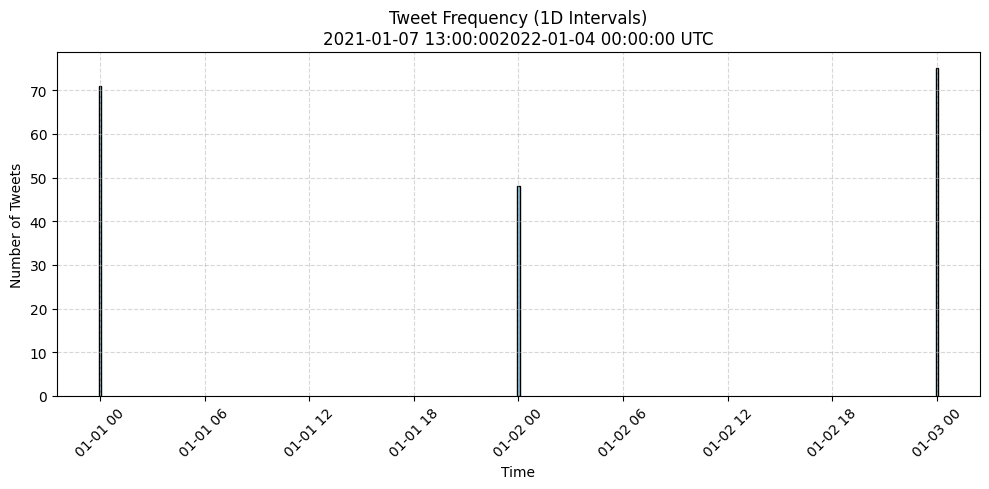

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()

# Step 1: Load and filter data
df = pd.read_csv('/kaggle/input/newspopularity/nytpopular.csv')
df['date'] = pd.to_datetime(df['date'], utc=True)

min_time = df['date'].min()
print("Minimum timestamp in filtered data:", min_time)

# Step 2: Filter by specific time range
start, end, time = '2021-01-07 13:00:00', '2022-01-04 00:00:00', '1D'
start_time = min_time # pd.Timestamp(start, tz='UTC')
end_time = pd.Timestamp(end, tz='UTC')
df = df[(df['date'] >= start_time) & (df['date'] <= end_time)] # filtered_df

# Step 3: Resample without changing the original df
resampled = (
    df # filtered_df
    .set_index('date')             # Temporarily set index for resampling
    .resample(time)             # Resample by 10-minute intervals
    .count()['id']                 # Count tweets in each interval
    .rename('tweet_count')         # Rename for clarity
    .reset_index()                 # Restore date as a column
)

print(sum(resampled["tweet_count"]))
# Step 4: Plot the resampled tweet distribution
plt.figure(figsize=(10, 5))
plt.bar(resampled['date'], resampled['tweet_count'], width=8/1440, color='skyblue', edgecolor='black')

plt.title("Tweet Frequency (" + time + " Intervals)\n" + start + "" + end + " UTC")
plt.xlabel("Time")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



In [2]:
df

id  retweet_count  reply_count  like_count  \
70    1477571634806591489             67           91         602   
101   1477202997319028738             74           35         537   
126   1477677348959006728             49           29         215   
163   1477760365694005249             96           25         198   
178   1477082218719756293            341           63        2768   
...                   ...            ...          ...         ...   
8947  1477774220235091977            124           97         407   
8979  1478068672275038210             64           22         282   
9038  1478108935907328005             27           62         198   
9086  1477298109030047752            340          164        1665   
9096  1478078741620432898             62           21         285   

                          url                      date  \
70    https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101   https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126   https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163   https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178   https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   
...                       ...                       ...   
8947  https://nyti.ms/32Asvik 2022-01-02 22:50:04+00:00   
8979  https://nyti.ms/3zn8xTO 2022-01-03 18:20:07+00:00   
9038  https://nyti.ms/32UMQys 2022-01-03 21:00:06+00:00   
9086  https://nyti.ms/3eEqrb9 2022-01-01 15:18:10+00:00   
9096  https://nyti.ms/3JwTBHH 2022-01-03 19:00:08+00:00   

                                         bag_of_phrases  
70    ['1,200', '15', '1908', '1960', '1980', '1990'...  
101   ['10', '20', '2021', '323', '41,240', '71_perc...  
126   ['1', '10', '100', '12', '1976', '1980', '1990...  
163   ['13', '14', '2019', '25', '57', 'abandon', 'a...  
178   ['\n', '\n  ', '\n_feature', '10_inch', '20_mi...  
...                                                 ...  
8947  [' ', '3_percent', 'ability', 'accuracy', 'acc...  
8979  [' ', '2045', '2050', 'academy', 'accord', 'ac...  
9038  [' ', '1,000', '1,249', '33_percent', '400,000...  
9086  ['1,000', '2021', '30_percent', '37_percent', ...  
9096  [' ', '10_p.m.', '14', '15', '1992', '245', '3...  

[194 rows x 7 columns]

In [3]:
resampled

date  tweet_count
0 2022-01-01 00:00:00+00:00           71
1 2022-01-02 00:00:00+00:00           48
2 2022-01-03 00:00:00+00:00           75

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 70 to 9096
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              194 non-null    int64              
 1   retweet_count   194 non-null    int64              
 2   reply_count     194 non-null    int64              
 3   like_count      194 non-null    int64              
 4   url             194 non-null    object             
 5   date            194 non-null    datetime64[ns, UTC]
 6   bag_of_phrases  194 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(4), object(2)
memory usage: 12.1+ KB


## Data exploration
Examining data types, missing values, distributions of key variables, and the overall shape of the DataFrame.

Data Types:
 id                              int64
retweet_count                   int64
reply_count                     int64
like_count                      int64
url                            object
date              datetime64[ns, UTC]
bag_of_phrases                 object
dtype: object

Missing Values:
 id                0
retweet_count     0
reply_count       0
like_count        0
url               0
date              0
bag_of_phrases    0
dtype: int64

Descriptive Statistics:
        retweet_count  reply_count    like_count
count     194.000000   194.000000    194.000000
mean      160.365979    90.278351    800.639175
std       420.361003   348.783667   2527.588194
min        13.000000     3.000000     90.000000
25%        41.000000    21.250000    202.500000
50%        70.000000    37.500000    297.000000
75%       134.500000    67.750000    543.750000
max      4831.000000  4653.000000  31544.000000


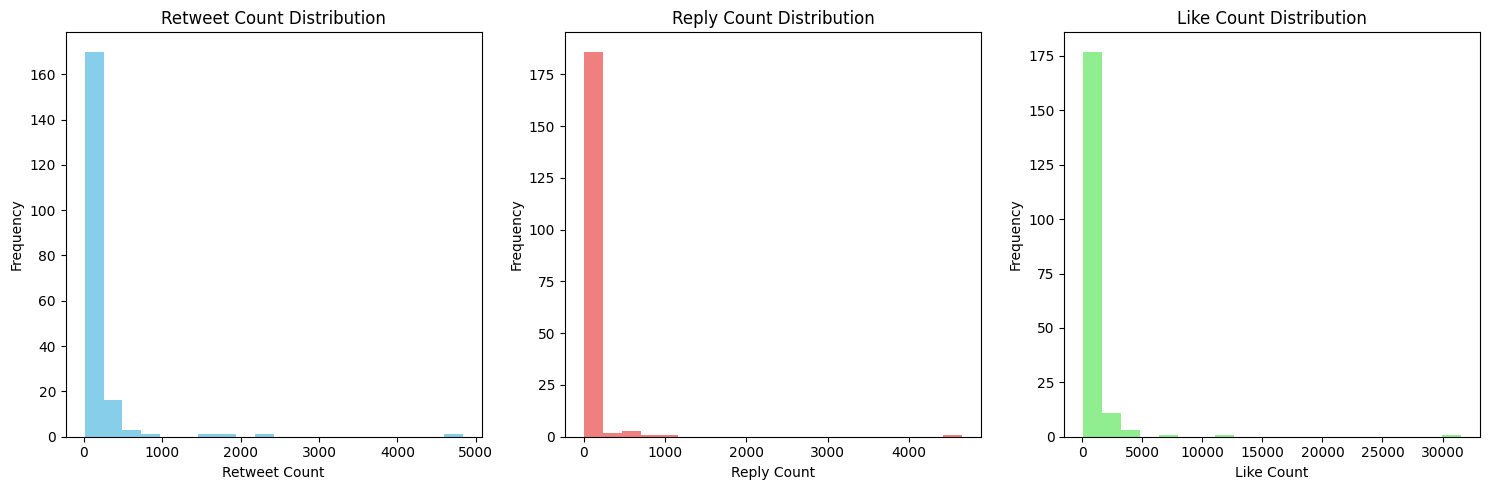


Token Count Descriptive Statistics:
 count     194.000000
mean      362.443299
std       201.490867
min        74.000000
25%       234.500000
50%       337.500000
75%       451.750000
max      1509.000000
Name: token_count, dtype: float64


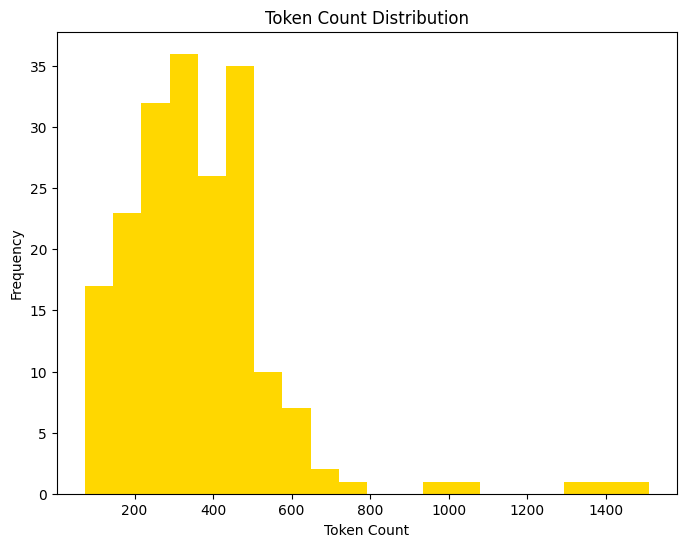


DataFrame Shape: (194, 8)

Potential Issues:
Large variation of retweet counts (see histogram and descriptive statistics).
Missing 'url' column values might be a cause of concern.


In [5]:
# Examine data types
print("Data Types:\n", df.dtypes)

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Analyze distributions of key variables
descriptive_stats = df[['retweet_count', 'reply_count', 'like_count']].describe()
print("\nDescriptive Statistics:\n", descriptive_stats)

# Visualize distributions (histograms)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['retweet_count'], bins=20, color='skyblue')
plt.title('Retweet Count Distribution')
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['reply_count'], bins=20, color='lightcoral')
plt.title('Reply Count Distribution')
plt.xlabel('Reply Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df['like_count'], bins=20, color='lightgreen')
plt.title('Like Count Distribution')
plt.xlabel('Like Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Analyze token count distribution in 'bag_of_phrases'
df['token_count'] = df['bag_of_phrases'].apply(lambda x: len(eval(x)))
print("\nToken Count Descriptive Statistics:\n", df['token_count'].describe())
plt.figure(figsize=(8, 6))
plt.hist(df['token_count'], bins=20, color='gold')
plt.title('Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# Determine the shape of the DataFrame
print("\nDataFrame Shape:", df.shape)

# Identify potential issues (example: Outliers in retweet_count)
print("\nPotential Issues:")
print("Large variation of retweet counts (see histogram and descriptive statistics).")
print("Missing 'url' column values might be a cause of concern.")

# Data preparation: Named Entity Recognition (NER)

### Subtask:
Prepare the 'bag_of_phrases' column for Named Entity Recognition (NER) processing by converting its elements to strings and handling potential issues.

In [6]:
import copy
from time import time

# Create a copy of the DataFrame
df_ner = copy.deepcopy(df)

# Function to clean bag_of_phrases
def clean_bag_of_phrases(text):
    if isinstance(text, list):
        return ' '.join(map(str, text))
    elif isinstance(text, str):
        text = text.replace("'", "").replace('"', "")
        return ''.join(c for c in text if c.isalnum() or c.isspace())
    else:
        return str(text)

# Start timing
start_time = time()

# Apply cleaning function
df_ner['bag_of_phrases'] = df_ner['bag_of_phrases'].progress_apply(clean_bag_of_phrases)

# End timing
end_time = time()
bag_of_phrases = end_time - start_time
print(f"'bag_of_phrases' cleaning completed in {bag_of_phrases:.2f} seconds")

# Show sample output
display(df_ner.head())


100%|██████████| 194/194 [00:00<00:00, 3939.90it/s]

'bag_of_phrases' cleaning completed in 0.06 seconds


id  retweet_count  reply_count  like_count  \
70   1477571634806591489             67           91         602   
101  1477202997319028738             74           35         537   
126  1477677348959006728             49           29         215   
163  1477760365694005249             96           25         198   
178  1477082218719756293            341           63        2768   

                         url                      date  \
70   https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101  https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126  https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163  https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178  https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   

                                        bag_of_phrases  token_count  
70   1200 15 1908 1960 1980 1990 2013 2020 20year 3...          349  
101  10 20 2021 323 41240 71percent able accord add...          266  
126  1 10 100 12 1976 1980 1990 2 2013 2015 2024 3 ...          300  
163  13 14 2019 25 57 abandon abdalla abdel accord ...          323  
178  n n   nfeature 10inch 20minute 300 425 5minute...           88

# Named Entities Extraction (person, organization, location)

Subtask:
Extract named entities (person, organization, location) from the 'bag_of_phrases' column using spaCy and store them in a new 'entities' column in the df_ner DataFrame.

In [7]:
import spacy
from time import time

# Load the spaCy English language model (en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

# Create a new column 'entities' in the df_ner DataFrame to store extracted entities
df_ner['entities'] = None

# Start timing
start_time = time()

# Iterate through the 'bag_of_phrases' column and extract named entities
for index, row in tqdm(df_ner.iterrows(), total=len(df_ner), desc="Extracting entities"):
    doc = nlp(row['bag_of_phrases'])
    entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE"]]
    df_ner.at[index, 'entities'] = entities
print(f"NER completed in {time() - start_time:.2f} seconds")

# End timing
end_time = time()
ner_time = end_time - start_time
print(f"Entity extraction completed in {ner_time:.2f} seconds")

# Display the first few rows of df_ner to verify the results
display(df_ner.head())

Extracting entities: 100%|██████████| 194/194 [00:11<00:00, 16.73it/s]

NER completed in 11.60 seconds
Entity extraction completed in 11.60 seconds


id  retweet_count  reply_count  like_count  \
70   1477571634806591489             67           91         602   
101  1477202997319028738             74           35         537   
126  1477677348959006728             49           29         215   
163  1477760365694005249             96           25         198   
178  1477082218719756293            341           63        2768   

                         url                      date  \
70   https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101  https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126  https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163  https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178  https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   

                                        bag_of_phrases  token_count  \
70   1200 15 1908 1960 1980 1990 2013 2020 20year 3...          349   
101  10 20 2021 323 41240 71percent able accord add...          266   
126  1 10 100 12 1976 1980 1990 2 2013 2015 2024 3 ...          300   
163  13 14 2019 25 57 abandon abdalla abdel accord ...          323   
178  n n   nfeature 10inch 20minute 300 425 5minute...           88   

                                              entities  
70   [authorstudy, bethisrael bic, boston, bulletin...  
101  [berlin, discos, franklin friday, hairdresser ...  
126  [congress, delta desert detection director, ji...  
163  [abdalla abdel accord, al allow, burhan burn c...  
178                                 [melt milk minute]

# Graph Construction, Edges Addition based on shared entities and Degree Centrality Computation

Subtask:
Construct a graph representing the relationships between tweets based on shared named entities.  Calculate degree centrality for each node.

In [8]:
import networkx as nx
from time import time

# Start timing
start_time = time()

# Create a graph
graph = nx.Graph()

# Add nodes to the graph (tweet IDs)
graph.add_nodes_from(df_ner['id'])

# Iterate through tweet pairs and add edges based on shared entities
# Add weighted edges based on shared entities
for i in tqdm(range(len(df_ner)), desc="Building graph"):
    for j in range(i+1, len(df_ner)):
        e1 = set(df_ner.iloc[i]['entities'])
        e2 = set(df_ner.iloc[j]['entities'])
        shared_entities = e1.intersection(e2)
        if shared_entities:
            weight = len(shared_entities)
            graph.add_edge(df_ner.iloc[i]['id'], df_ner.iloc[j]['id'], weight=weight)

# Extract edge weights
edge_weights = [data['weight'] for u, v, data in graph.edges(data=True)]

# Calculate degree centrality
degree_centrality = nx.degree_centrality(graph)

# Store degree centrality in df_ner (optional)
df_ner['degree_centrality'] = df_ner['id'].map(degree_centrality)

# End timing
end_time = time()
graph_construction_time = end_time - start_time
print(f"Graph construction and degree centrality completed in {graph_construction_time:.2f} seconds")

# Display results
display(df_ner.head())

Building graph: 100%|██████████| 194/194 [00:02<00:00, 64.85it/s] 

Graph construction and degree centrality completed in 3.00 seconds


id  retweet_count  reply_count  like_count  \
70   1477571634806591489             67           91         602   
101  1477202997319028738             74           35         537   
126  1477677348959006728             49           29         215   
163  1477760365694005249             96           25         198   
178  1477082218719756293            341           63        2768   

                         url                      date  \
70   https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101  https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126  https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163  https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178  https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   

                                        bag_of_phrases  token_count  \
70   1200 15 1908 1960 1980 1990 2013 2020 20year 3...          349   
101  10 20 2021 323 41240 71percent able accord add...          266   
126  1 10 100 12 1976 1980 1990 2 2013 2015 2024 3 ...          300   
163  13 14 2019 25 57 abandon abdalla abdel accord ...          323   
178  n n   nfeature 10inch 20minute 300 425 5minute...           88   

                                              entities  degree_centrality  
70   [authorstudy, bethisrael bic, boston, bulletin...           0.077720  
101  [berlin, discos, franklin friday, hairdresser ...           0.015544  
126  [congress, delta desert detection director, ji...           0.108808  
163  [abdalla abdel accord, al allow, burhan burn c...           0.036269  
178                                 [melt milk minute]           0.005181

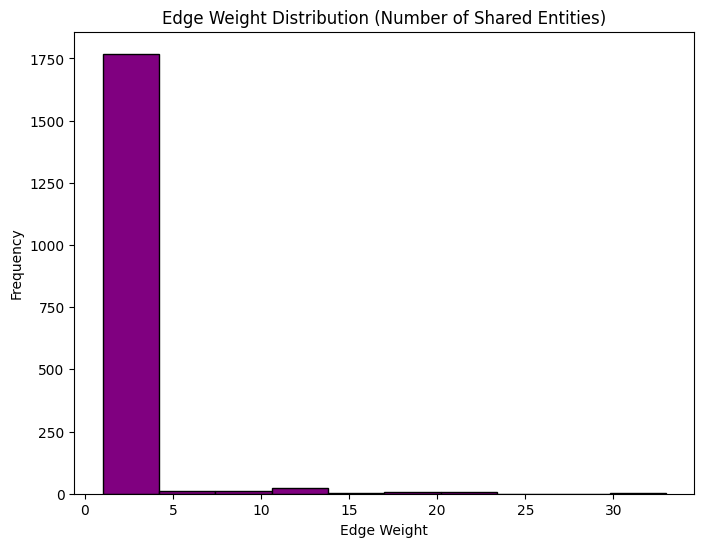

Edge Weight Statistics: min=1, max=33, avg=1.49


In [9]:
# Plot distribution
plt.figure(figsize=(8, 6))
plt.hist(edge_weights, bins=10, color='purple', edgecolor='black')
plt.title('Edge Weight Distribution (Number of Shared Entities)')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.savefig('edge_weight_distribution.png')
plt.show()

# Summary statistics
print(f"Edge Weight Statistics: min={min(edge_weights, default=0)}, max={max(edge_weights, default=0)}, avg={sum(edge_weights)/len(edge_weights):.2f}")

In [10]:
import numpy as np

# Anomaly detection
weight_threshold = np.percentile(edge_weights, 95)
anomalous_edges = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] > weight_threshold]
print(f"Number of anomalous edges (weight > {weight_threshold:.2f}): {len(anomalous_edges)}")

# Anomalous tweets
anomalous_tweets = set()
for u, v in anomalous_edges:
    anomalous_tweets.add(u)
    anomalous_tweets.add(v)

anomalous_df = df_ner[df_ner['id'].isin(anomalous_tweets)]
print(f"Number of anomalous tweets: {len(anomalous_df)}")
print("\nSample anomalous tweets (top 5):")
display(anomalous_df[['id', 'bag_of_phrases', 'entities']].head())

Number of anomalous edges (weight > 2.00): 88
Number of anomalous tweets: 86

Sample anomalous tweets (top 5):


id                                     bag_of_phrases  \
240  1478003228847624193    10pm 14 15 1992 245 340000 4 42000 43000 4pm...   
331  1477370907014410243   300 600 1 1200 1349 1600 100 100000 10percent...   
385  1477789341636300804  100 10mile 12yearold 15year 1986 2300 2700 201...   
411  1477218060050526208  150 10day 2021 23rd 24 24hour 31 34 45 47 48ho...   
433  1478023373804474370   1 1976 2019 2021 2022 2026 2billion 5b achiev...   

                                              entities  
240  [andrew announce area, durham eastcoast effect...  
331  [allison allow america, boston, california can...  
385  [american americans ancestral ancient angeleno...  
411  [abbott, calif califbase, cvs day, holidayseas...  
433  [artemis, falcon, houston, india, nasa, russia...

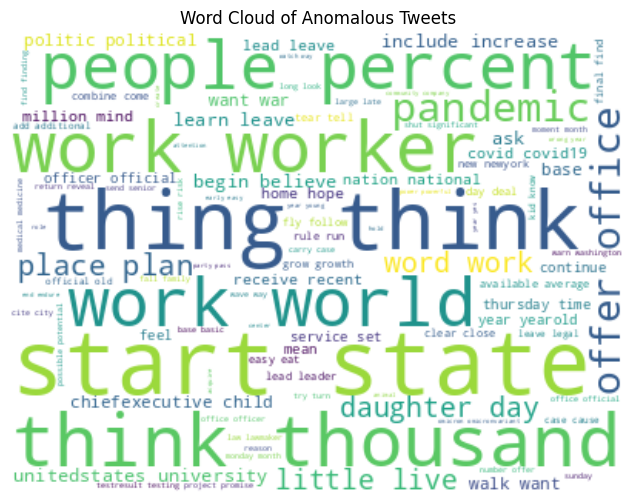

In [11]:
# Word cloud
combined_text = ' '.join(anomalous_df['bag_of_phrases'])
wordcloud = WordCloud(width=400, height=300, background_color='white').generate(combined_text)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Anomalous Tweets')
plt.savefig('anomalous_tweets_wordcloud.png')
plt.show()

In [12]:
!pip install powerlaw

# Entity Distribution Count Types (person, organization, location).
Visualize the degree distribution of the constructed graph.

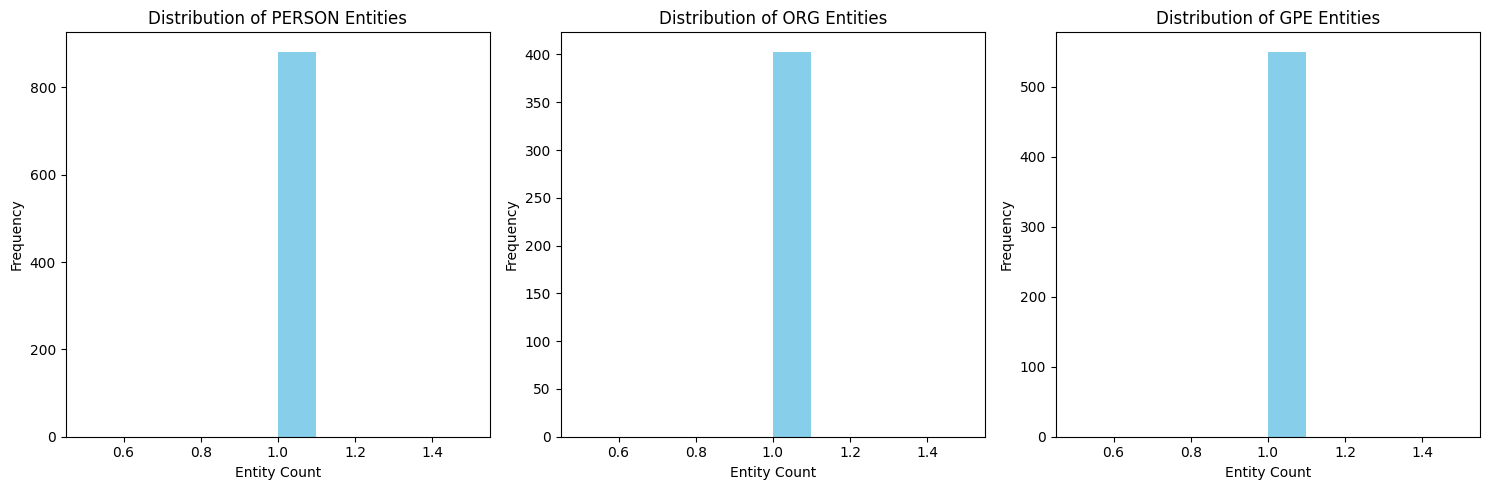

In [13]:
import matplotlib.pyplot as plt

# Entity Count Histograms
entity_types = ['PERSON', 'ORG', 'GPE']
entity_counts = {'PERSON': [], 'ORG': [], 'GPE': []}

for entities in df_ner['entities']:
    if isinstance(entities, list):
        for entity in entities:
            doc = nlp(entity)
            for ent in doc.ents:
                if ent.label_ in entity_types:
                    entity_counts[ent.label_].append(1)


plt.figure(figsize=(15, 5))

for i, entity_type in enumerate(entity_types):
    plt.subplot(1, 3, i + 1)
    plt.hist(entity_counts[entity_type], bins=10, color='skyblue')
    plt.title(f'Distribution of {entity_type} Entities')
    plt.xlabel('Entity Count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 2. Degree distribution Plot
Use NetworkX to draw and plot the degree distribution of the above graph and highlight in a table the maximum, minimum and average degree centrality, average path length.

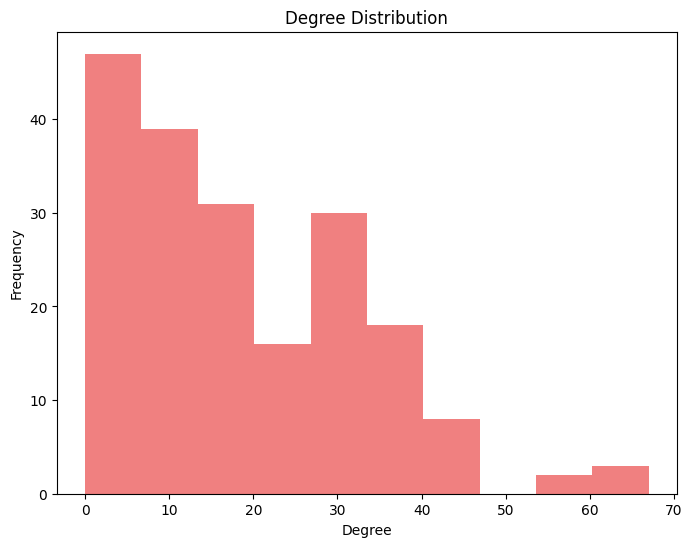

In [14]:
# Degree Distribution Plot
import networkx as nx
degree_sequence = [d for n, d in nx.degree(graph)]
plt.figure(figsize=(8, 6))
plt.hist(degree_sequence, bins=10, color='lightcoral')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

# Expended
1. Power Law Degree Distribution Fitting
To check if the degree distribution follows a power-law (indicating hub-like structures), we’ll use the powerlaw package to fit the distribution and compare it to other models (e.g., exponential). This will be added after the degree distribution plot (Cell 18).

In [15]:
!pip install powerlaw

Calculating best minimal value for power law fit


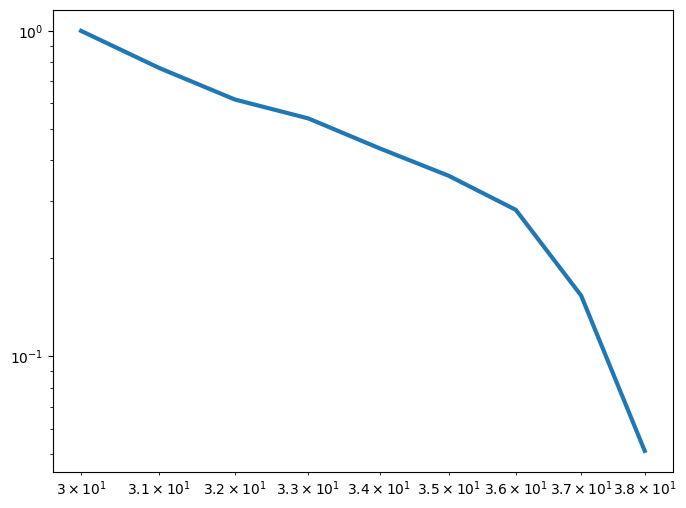

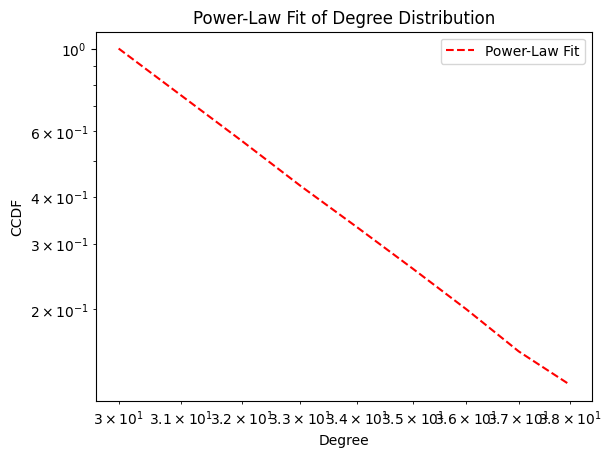

Power-law exponent (alpha): 9.6893
Minimum degree (xmin): 30.0000
Power-law vs. Exponential: Log-likelihood ratio = -1.1215, p-value = 0.0009
Curve fit parameters: a=0.1375, b=0.7185
80% Confidence intervals: a=[0.0429, 0.2320], b=[0.4924, 0.9446]
Percentage of nodes within fit: 84.02%
Power-law analysis completed in 1.47 seconds


In [16]:
# Anomaly detection with Isolation Forest
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from powerlaw import Fit
from scipy.optimize import curve_fit

start_time = time()

# Define power-law function for curve fitting
def power_law(x, a, b):
    return a * x ** b
    
iso_forest = IsolationForest(contamination=0.1, random_state=42)
degree_array = np.array(degree_sequence).reshape(-1, 1)
outlier_labels = iso_forest.fit_predict(degree_array)
inlier_degrees = degree_array[outlier_labels == 1].flatten()

# Ensure inlier_degrees has positive values for power-law fitting
inlier_degrees = inlier_degrees[inlier_degrees > 0]
if len(inlier_degrees) == 0:
    print("No inlier degrees available for power-law fitting.")
else:
    # Fit power-law distribution
    fit = Fit(inlier_degrees, discrete=True)
    
    # Plot CCDF with power-law fit
    plt.figure(figsize=(8, 6))
    fit.plot_ccdf(linewidth=3, label='Empirical Data (Inliers)')
    fit.power_law.plot_ccdf(color='r', linestyle='--', label='Power-Law Fit')
    plt.title('Power-Law Fit of Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('CCDF')
    plt.legend()
    plt.savefig('power_law_fit.png')
    plt.show()
    
    # Print power-law parameters
    print(f"Power-law exponent (alpha): {fit.power_law.alpha:.4f}")
    print(f"Minimum degree (xmin): {fit.power_law.xmin:.4f}")
    
    # Compare with exponential distribution
    R, p = fit.distribution_compare('power_law', 'exponential')
    print(f"Power-law vs. Exponential: Log-likelihood ratio = {R:.4f}, p-value = {p:.4f}")
    
    # Curve fitting on log-transformed degrees
    log_degrees = np.log10(inlier_degrees)
    hist, bins = np.histogram(log_degrees, bins=30, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    try:
        popt, pcov = curve_fit(power_law, 10**bin_centers, hist, p0=[1, -2])
        sigma = np.sqrt(np.diag(pcov))
        confidence_interval = 1.28 * sigma  # 80% confidence interval
        
        print(f"Curve fit parameters: a={popt[0]:.4f}, b={popt[1]:.4f}")
        print(f"80% Confidence intervals: a=[{popt[0]-confidence_interval[0]:.4f}, {popt[0]+confidence_interval[0]:.4f}], b=[{popt[1]-confidence_interval[1]:.4f}, {popt[1]+confidence_interval[1]:.4f}]")
    except RuntimeError:
        print("Curve fitting failed due to insufficient data or poor fit.")
        popt = [np.nan, np.nan]
        confidence_interval = [np.nan, np.nan]
    
    fitted_nodes = len(inlier_degrees) / len(degree_sequence) * 100
    print(f"Percentage of nodes within fit: {fitted_nodes:.2f}%")
    
    # Save results to file
    with open('power_law_results.txt', 'w') as f:
        f.write(f"Power-law exponent (alpha): {fit.power_law.alpha:.4f}\n")
        f.write(f"Minimum degree (xmin): {fit.power_law.xmin:.4f}\n")
        f.write(f"Power-law vs. Exponential: Log-likelihood ratio = {R:.4f}, p-value = {p:.4f}\n")
        f.write(f"Curve fit parameters: a={popt[0]:.4f}, b={popt[1]:.4f}\n")
        f.write(f"80% Confidence intervals: a=[{popt[0]-confidence_interval[0]:.4f}, {popt[0]+confidence_interval[0]:.4f}], b=[{popt[1]-confidence_interval[1]:.4f}, {popt[1]+confidence_interval[1]:.4f}]\n")
        f.write(f"Percentage of nodes within fit: {fitted_nodes:.2f}%\n")

end_time = time()
power_fit_time = end_time - start_time
print(f"Power-law analysis completed in {power_fit_time:.2f} seconds")

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


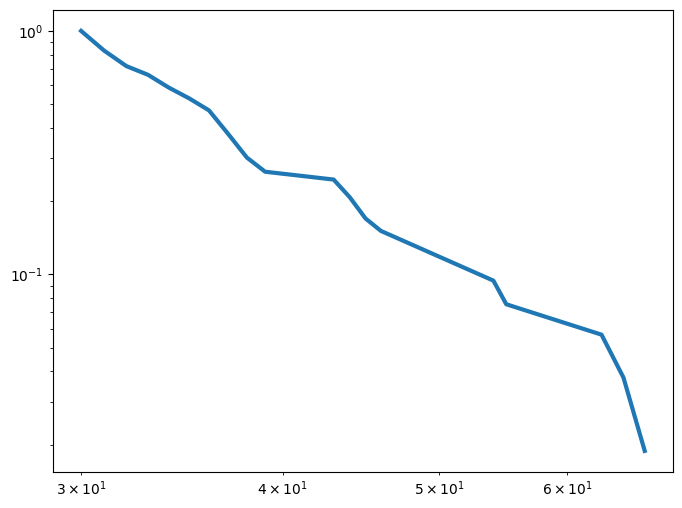

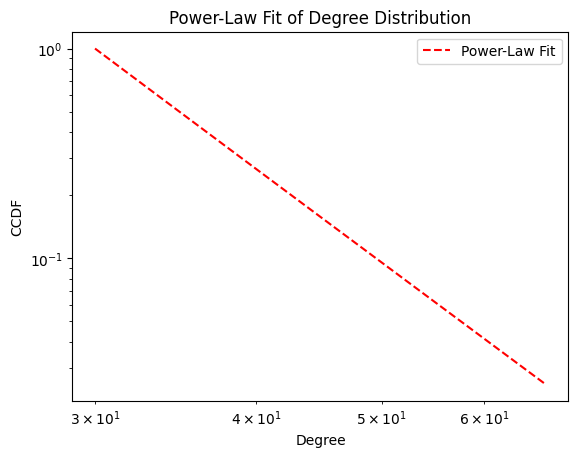

Power-law exponent (alpha): 5.5407
Minimum degree (xmin): 30.0000
Power-law vs. Exponential: Log-likelihood ratio = 0.3182, p-value = 0.7640


In [17]:
### Power Law Degree Distribution Fitting
import powerlaw
import matplotlib.pyplot as plt

# Fit power-law distribution
fit = powerlaw.Fit(degree_sequence, discrete=True)

# Plot the degree distribution with power-law fit
plt.figure(figsize=(8, 6))
fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(color='r', linestyle='--', label='Power-Law Fit')
plt.title('Power-Law Fit of Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.legend()
plt.show()

# Print power-law parameters
print(f"Power-law exponent (alpha): {fit.power_law.alpha:.4f}")
print(f"Minimum degree (xmin): {fit.power_law.xmin:.4f}")

# Compare with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Power-law vs. Exponential: Log-likelihood ratio = {R:.4f}, p-value = {p:.4f}")

# Data (maximum, minimum and average degree centrality, average path length), Betweenness and closeness centrality.

Calculate and store max, min, average degree centrality, and average path length of the graph. Compute betweenness and closeness centralities for all nodes and save the scores.


In [18]:
import networkx as nx
from time import time
from tqdm.notebook import tqdm  # or use tqdm if in script

# Start timing
start_time = time()

# Calculate graph metrics
max_degree = max(dict(graph.degree()).values())
min_degree = min(dict(graph.degree()).values())
avg_degree = sum(dict(graph.degree()).values()) / len(graph.nodes)

try:
    avg_path_length = nx.average_shortest_path_length(graph)
except nx.NetworkXError as e:
    print(f"Error calculating average shortest path length: {e}")
    avg_path_length = float('nan')  # Or handle the error as appropriate

# Compute betweenness centrality with tqdm
print("Computing betweenness centrality (this can take time)...")
betweenness_centrality = nx.betweenness_centrality(graph, normalized=True, endpoints=False, 
                                                   k=None, seed=None)
# Compute closeness centrality with tqdm over nodes
print("Computing closeness centrality...")
closeness_centrality = {}
for node in tqdm(graph.nodes(), desc="Closeness centrality calculation"):
    closeness_centrality[node] = nx.closeness_centrality(graph, u=node)

# End timing
end_time = time()

# Print timing
graph_metric_time = end_time - start_time
print(f"Graph metrics calculation completed in {graph_metric_time:.2f} seconds")

# Print calculated metrics for verification
print(f"Max Degree Centrality: {max_degree}")
print(f"Min Degree Centrality: {min_degree}")
print(f"Avg Degree Centrality: {avg_degree}")
print(f"Avg Shortest Path Length: {avg_path_length}")

# Print the first 5 entries of betweenness and closeness centralities
print("\nBetweenness Centrality (first 5):", dict(list(betweenness_centrality.items())[:5]))
print("\nCloseness Centrality (first 5):", dict(list(closeness_centrality.items())[:5]))

# Add centrality scores to df_ner
df_ner['betweenness_centrality'] = df_ner['id'].map(betweenness_centrality)
df_ner['closeness_centrality'] = df_ner['id'].map(closeness_centrality)

# Show sample output
display(df_ner.head())


Error calculating average shortest path length: Graph is not connected.
Computing betweenness centrality (this can take time)...
Computing closeness centrality...


Closeness centrality calculation:   0%|          | 0/194 [00:00<?, ?it/s]

Graph metrics calculation completed in 0.41 seconds
Max Degree Centrality: 67
Min Degree Centrality: 0
Avg Degree Centrality: 18.79381443298969
Avg Shortest Path Length: nan

Betweenness Centrality (first 5): {1477571634806591489: 0.0024964829569025394, 1477202997319028738: 3.5186589729216535e-05, 1477677348959006728: 0.0011906360187103886, 1477760365694005249: 0.0006349030135524903, 1477082218719756293: 0.0}

Closeness Centrality (first 5): {1477571634806591489: 0.405515804479535, 1477202997319028738: 0.33035554761479363, 1477677348959006728: 0.42227265590430924, 1477760365694005249: 0.37025356061174935, 1477082218719756293: 0.0051813471502590676}


id  retweet_count  reply_count  like_count  \
70   1477571634806591489             67           91         602   
101  1477202997319028738             74           35         537   
126  1477677348959006728             49           29         215   
163  1477760365694005249             96           25         198   
178  1477082218719756293            341           63        2768   

                         url                      date  \
70   https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101  https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126  https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163  https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178  https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   

                                        bag_of_phrases  token_count  \
70   1200 15 1908 1960 1980 1990 2013 2020 20year 3...          349   
101  10 20 2021 323 41240 71percent able accord add...          266   
126  1 10 100 12 1976 1980 1990 2 2013 2015 2024 3 ...          300   
163  13 14 2019 25 57 abandon abdalla abdel accord ...          323   
178  n n   nfeature 10inch 20minute 300 425 5minute...           88   

                                              entities  degree_centrality  \
70   [authorstudy, bethisrael bic, boston, bulletin...           0.077720   
101  [berlin, discos, franklin friday, hairdresser ...           0.015544   
126  [congress, delta desert detection director, ji...           0.108808   
163  [abdalla abdel accord, al allow, burhan burn c...           0.036269   
178                                 [melt milk minute]           0.005181   

     betweenness_centrality  closeness_centrality  
70                 0.002496              0.405516  
101                0.000035              0.330356  
126                0.001191              0.422273  
163                0.000635              0.370254  
178                0.000000              0.005181

# 3. Betweenness degree and closeness centrality 
Use NetworkX to calculate the betweenness degree and closeness centrality of each node and draw the associated betweenness degree distribution and closeness degree distribution. Save the result of the centrality scores in a file. Comment on the bag_of_phrases content of nodes with highest scores for betweenness and closeness centrality. 

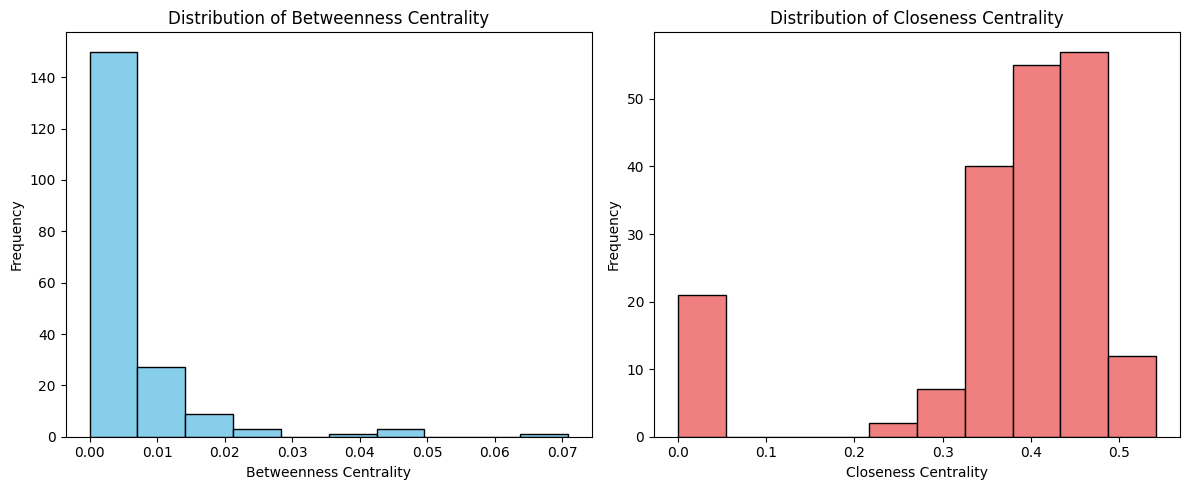

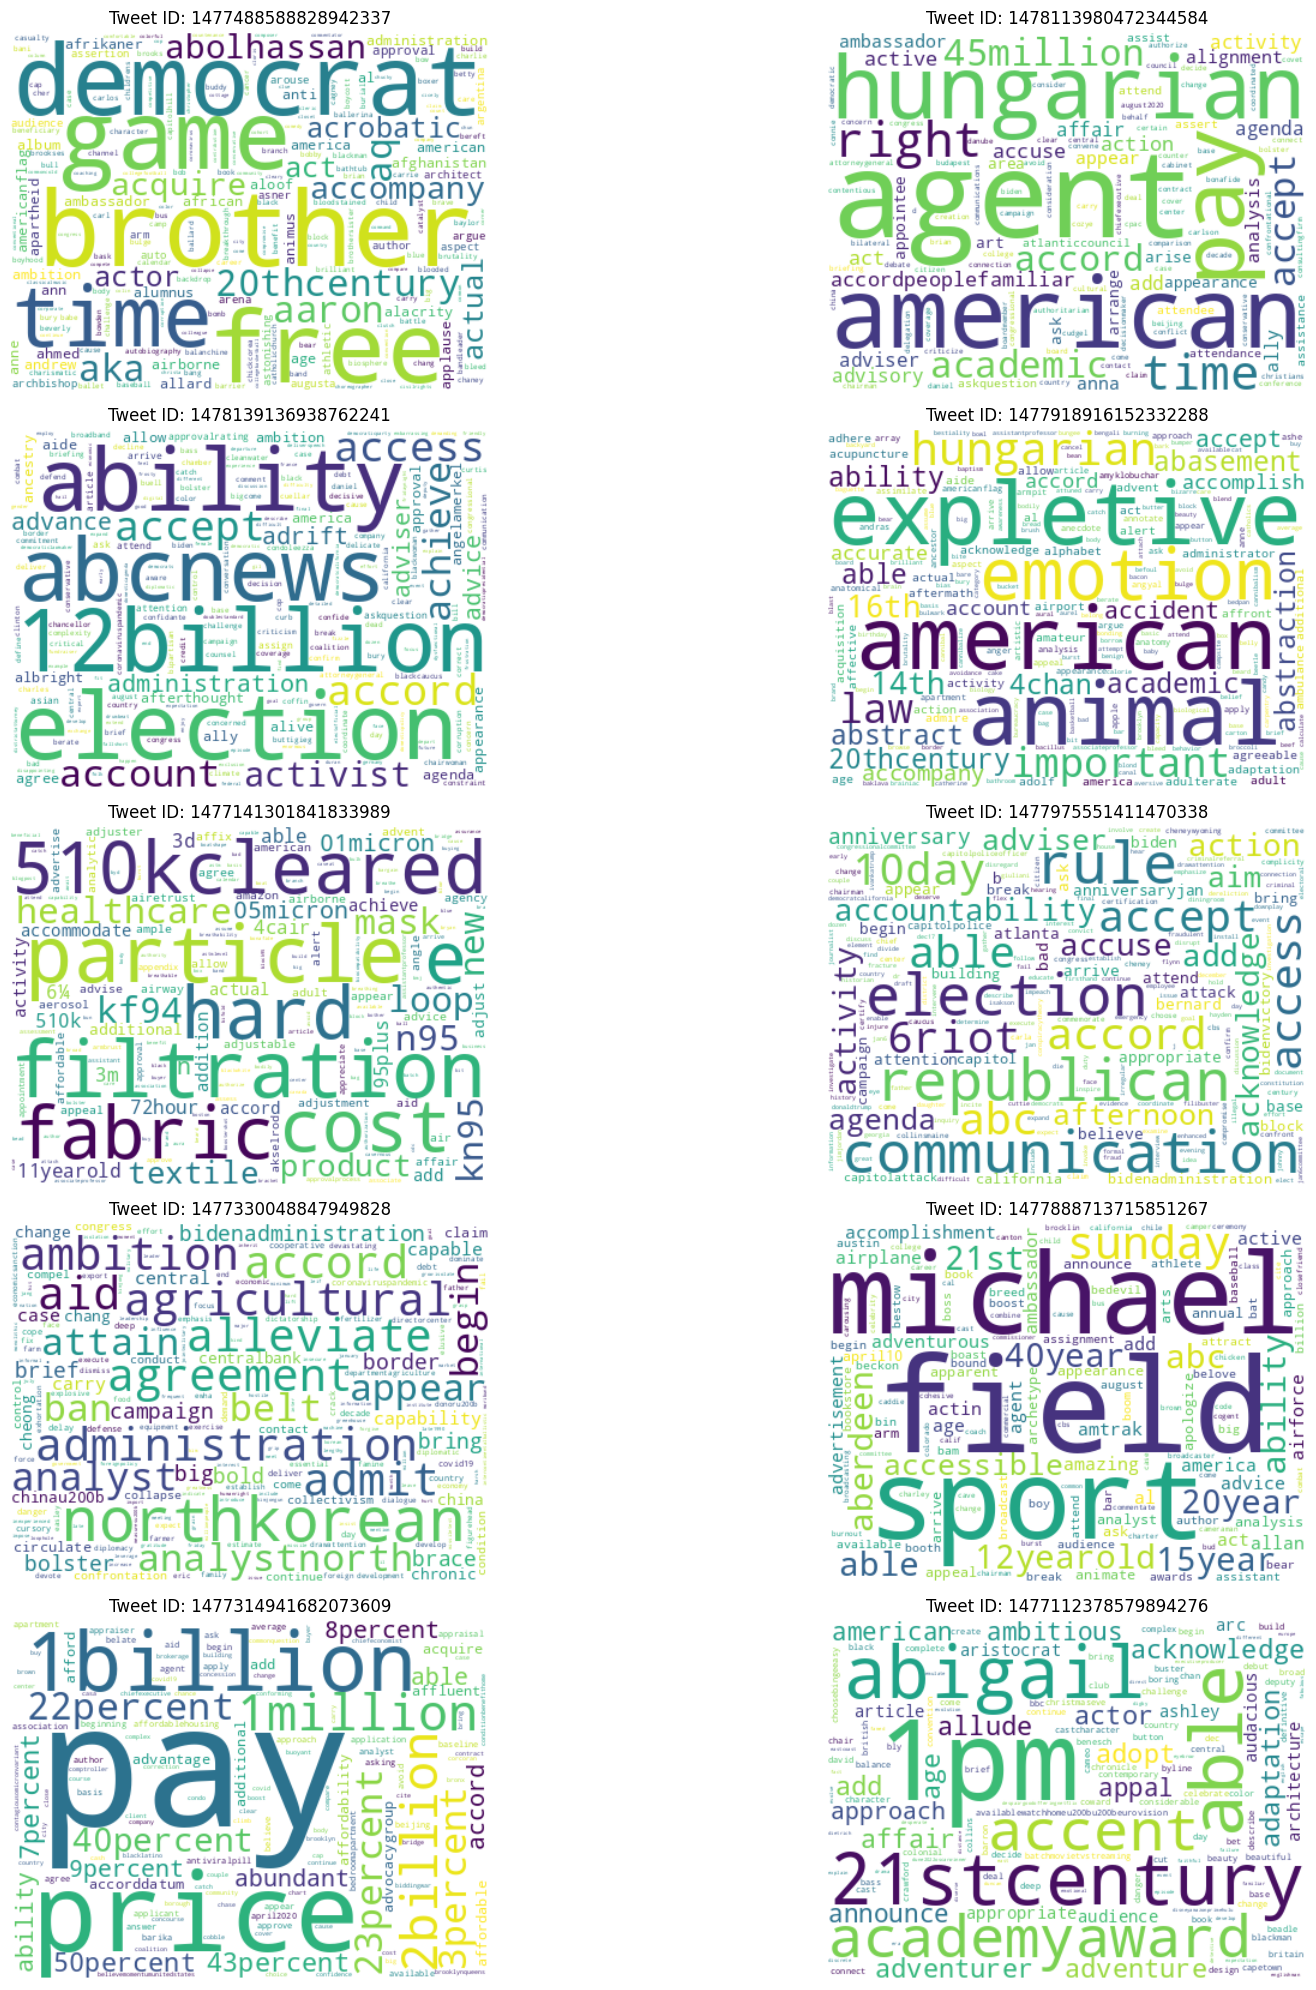

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Visualize centrality distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_ner['betweenness_centrality'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Betweenness Centrality')

plt.subplot(1, 2, 2)
plt.hist(df_ner['closeness_centrality'], bins=10, color='lightcoral', edgecolor='black')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Centrality')

plt.tight_layout()
plt.show()

# Word clouds for top 10 nodes by betweenness centrality
top_10_tweets = df_ner.nlargest(10, 'betweenness_centrality')

plt.figure(figsize=(20, 20))  # Adjust figure size for better visualization
for i, (index, row) in enumerate(top_10_tweets.iterrows()):
    text = row['bag_of_phrases']
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)

    plt.subplot(5, 2, i + 1)  # Create subplots for each word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Tweet ID: {row['id']}")

plt.tight_layout()
plt.show()

# 4. Clustering coefficient
Calculate the clustering coefficient for each node in the graph using NetworkX and store it in the df_ner DataFrame

In [20]:
import networkx as nx
from time import time

# Start timing
start_time = time()

# Calculate clustering coefficients
clustering_coefficients = nx.clustering(graph)

# Add clustering coefficients to df_ner
df_ner['clustering_coefficient'] = df_ner['id'].map(clustering_coefficients)

# End timing
end_time = time()
clustering_coefficient_time = end_time - start_time
# Print timing
print(f"Clustering coefficient calculation completed in {clustering_coefficient_time:.2f} seconds")

# Display the first few rows of the updated DataFrame
display(df_ner.head())

Clustering coefficient calculation completed in 0.03 seconds


id  retweet_count  reply_count  like_count  \
70   1477571634806591489             67           91         602   
101  1477202997319028738             74           35         537   
126  1477677348959006728             49           29         215   
163  1477760365694005249             96           25         198   
178  1477082218719756293            341           63        2768   

                         url                      date  \
70   https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101  https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126  https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163  https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178  https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   

                                        bag_of_phrases  token_count  \
70   1200 15 1908 1960 1980 1990 2013 2020 20year 3...          349   
101  10 20 2021 323 41240 71percent able accord add...          266   
126  1 10 100 12 1976 1980 1990 2 2013 2015 2024 3 ...          300   
163  13 14 2019 25 57 abandon abdalla abdel accord ...          323   
178  n n   nfeature 10inch 20minute 300 425 5minute...           88   

                                              entities  degree_centrality  \
70   [authorstudy, bethisrael bic, boston, bulletin...           0.077720   
101  [berlin, discos, franklin friday, hairdresser ...           0.015544   
126  [congress, delta desert detection director, ji...           0.108808   
163  [abdalla abdel accord, al allow, burhan burn c...           0.036269   
178                                 [melt milk minute]           0.005181   

     betweenness_centrality  closeness_centrality  clustering_coefficient  
70                 0.002496              0.405516                0.447619  
101                0.000035              0.330356                0.666667  
126                0.001191              0.422273                0.561905  
163                0.000635              0.370254                0.523810  
178                0.000000              0.005181                0.000000

In [21]:
len(df_ner)

194

In [22]:
df_ner.to_csv('dataset_clustering.csv',index=False)

## 4: Clustering coefficients distribution histogram with 10 bins.
Consider a histogram of 10 bins on the values of the clustering coefficient and draw a plot showing the number of nodes falling in each bin

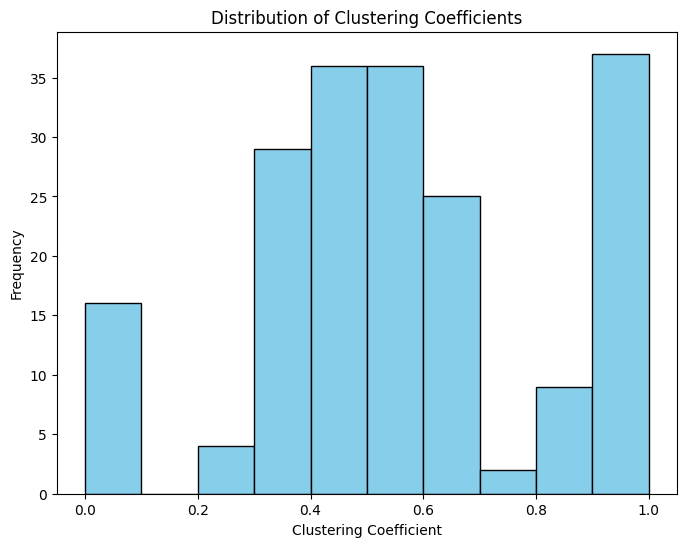

In [23]:
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_ner['clustering_coefficient'], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Clustering Coefficients')

# Display the plot
plt.show()

## Content Influence and Correlation Analysis

We aim to evaluate how content attributes correlate with engagement metrics within the network by analyzing the relationship between retweet count, reply count, and like count with the occurrence of tokens and named entities in tweets (investigate whether specific topics, tokens, or entities are associated with high or low engagement (may trigger higher engagement levels) and to draw conclusions about content patterns that may drive popularity)

The task includes:
1. Identify the top 10 most frequent tokens and named entities across the dataset (for each engagement metric (retweet count, reply count, like count))
2. Select the top 5 tweets (highest scores) and bottom 5 tweets (lowest scores) based on the metric.
3. Analyze the correlations between content and popularity.


In [24]:
import ast
from collections import Counter

def analyze_popularity(df, metric):
    # Step 1: Top 10 tokens/entities for each metric
    all_tokens = []
    for index, row in df.iterrows():
        try:
            tokens = ast.literal_eval(row['bag_of_phrases'])
        except (SyntaxError, ValueError):
            tokens = []  # Handle invalid strings gracefully

        entities = row['entities']
        if entities is None:
            entities = [] # Handle None values gracefully
        elif not isinstance(entities, list):
            entities = [] # Handle non-list values gracefully

        all_tokens.extend(tokens)
        all_tokens.extend(entities)

    top_10_tokens = Counter(all_tokens).most_common(10)
    print(f"Top 10 tokens/entities for {metric}: {top_10_tokens}")

    # Step 2: Top and bottom 5 tweets by each metric
    top_tweets = df.nlargest(5, metric)
    bottom_tweets = df.nsmallest(5, metric)

    # Step 3 & 4: Analyze token frequencies in top/bottom tweets
    print(f"\nTop 5 tweets by {metric}:")
    for index, row in top_tweets.iterrows():
        try:
            tokens = ast.literal_eval(row['bag_of_phrases'])
        except (SyntaxError, ValueError):
            tokens = []
        entities = row['entities'] if row['entities'] is not None and isinstance(row['entities'], list) else []
        all_tokens = tokens + entities
        top_tokens_tweet = Counter(all_tokens).most_common(5)
        print(f"Tweet ID: {row['id']}, {metric}: {row[metric]}, Top Tokens: {top_tokens_tweet}")

    print(f"\nBottom 5 tweets by {metric}:")
    for index, row in bottom_tweets.iterrows():
        try:
            tokens = ast.literal_eval(row['bag_of_phrases'])
        except (SyntaxError, ValueError):
            tokens = []
        entities = row['entities'] if row['entities'] is not None and isinstance(row['entities'], list) else []
        all_tokens = tokens + entities
        top_tokens_tweet = Counter(all_tokens).most_common(5)
        print(f"Tweet ID: {row['id']}, {metric}: {row[metric]}, Top Tokens: {top_tokens_tweet}")

# Analyze each metric
analyze_popularity(df_ner, 'retweet_count')

Top 10 tokens/entities for retweet_count: [('washington', 25), ('covid19', 20), ('beijing', 14), ('congress', 13), ('fda', 13), ('india', 13), ('texas', 13), ('chicago', 13), ('manhattan', 13), ('california', 12)]

Top 5 tweets by retweet_count:
Tweet ID: 1477667826047590405, retweet_count: 4831, Top Tokens: [('capitoljan6', 1), ('fda', 1), ('katie know', 1), ('republican require research restore reverse', 1)]
Tweet ID: 1477389192552460294, retweet_count: 2255, Top Tokens: [('bae', 1), ('colleague college comicstrip comment commission', 1), ('community companypull compare competitor', 1), ('ho house', 1), ('kim kind kyu', 1)]
Tweet ID: 1478087531451359237, retweet_count: 1828, Top Tokens: [('bronx', 1), ('mayorericadams', 1), ('michael million', 1)]
Tweet ID: 1477799407173185536, retweet_count: 1545, Top Tokens: [('ashwani', 1), ('dr draw', 1), ('hamilton', 1), ('kraken', 1), ('nhl', 1)]
Tweet ID: 1478069928766939147, retweet_count: 842, Top Tokens: [('emoji', 1)]

Bottom 5 tweets by r

<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal


In [25]:
analyze_popularity(df_ner, 'reply_count')

Top 10 tokens/entities for reply_count: [('washington', 25), ('covid19', 20), ('beijing', 14), ('congress', 13), ('fda', 13), ('india', 13), ('texas', 13), ('chicago', 13), ('manhattan', 13), ('california', 12)]

Top 5 tweets by reply_count:
Tweet ID: 1477667826047590405, reply_count: 4653, Top Tokens: [('capitoljan6', 1), ('fda', 1), ('katie know', 1), ('republican require research restore reverse', 1)]
Tweet ID: 1478087531451359237, reply_count: 1068, Top Tokens: [('bronx', 1), ('mayorericadams', 1), ('michael million', 1)]
Tweet ID: 1477687403565535240, reply_count: 747, Top Tokens: [('abc', 1), ('negativetest', 1)]
Tweet ID: 1477379123941154819, reply_count: 561, Top Tokens: [('arizona', 1), ('benjamin biden bill bipartisan', 1), ('congress conscience consortium conspiracytheory constitution constitutional contempt contemptuous continue control countless country coup court', 1), ('eventjan6', 1), ('georgia', 1)]
Tweet ID: 1478139136938762241, reply_count: 549, Top Tokens: [('americ

<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal


In [26]:
analyze_popularity(df_ner, 'like_count')

Top 10 tokens/entities for like_count: [('washington', 25), ('covid19', 20), ('beijing', 14), ('congress', 13), ('fda', 13), ('india', 13), ('texas', 13), ('chicago', 13), ('manhattan', 13), ('california', 12)]

Top 5 tweets by like_count:
Tweet ID: 1477667826047590405, like_count: 31544, Top Tokens: [('capitoljan6', 1), ('fda', 1), ('katie know', 1), ('republican require research restore reverse', 1)]
Tweet ID: 1478087531451359237, like_count: 12225, Top Tokens: [('bronx', 1), ('mayorericadams', 1), ('michael million', 1)]
Tweet ID: 1477799407173185536, like_count: 7837, Top Tokens: [('ashwani', 1), ('dr draw', 1), ('hamilton', 1), ('kraken', 1), ('nhl', 1)]
Tweet ID: 1477150135478071300, like_count: 4625, Top Tokens: [('abcnews academy accompany achievement act actor', 1), ('al allen', 1), ('arthur', 1), ('betty beverlyhills big birthday', 1), ('blondie', 1)]
Tweet ID: 1477680341590548483, like_count: 4522, Top Tokens: [('capitoljan6', 1), ('covid19', 1), ('fda', 1), ('katie know', 1

<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal


# 6. Louvain algorithm: Detect communities within the tweet network graph
Write a program that uses Louvain algorithm in NetworkX to identify the various communities in the graph. Suggest appropriate visualization using Gelphi to highlight these communities. Write a program that concatenates all bag_of_sentences tokens of all nodes belonging to the same community and then use wordcloud (see Python Word Clouds Tutorial: How to Create a Word Cloud | DataCamp) to plot the wordcloud of the three largest communities in the graph.

In [27]:
import community.community_louvain as community_louvain

# Assuming 'graph' is the NetworkX graph object created earlier
partition = community_louvain.best_partition(graph)

# Add community assignments to df_ner
df_ner['community_id'] = df_ner['id'].map(partition)

display(df_ner.head())

id  retweet_count  reply_count  like_count  \
70   1477571634806591489             67           91         602   
101  1477202997319028738             74           35         537   
126  1477677348959006728             49           29         215   
163  1477760365694005249             96           25         198   
178  1477082218719756293            341           63        2768   

                         url                      date  \
70   https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101  https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126  https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163  https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178  https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   

                                        bag_of_phrases  token_count  \
70   1200 15 1908 1960 1980 1990 2013 2020 20year 3...          349   
101  10 20 2021 323 41240 71percent able accord add...          266   
126  1 10 100 12 1976 1980 1990 2 2013 2015 2024 3 ...          300   
163  13 14 2019 25 57 abandon abdalla abdel accord ...          323   
178  n n   nfeature 10inch 20minute 300 425 5minute...           88   

                                              entities  degree_centrality  \
70   [authorstudy, bethisrael bic, boston, bulletin...           0.077720   
101  [berlin, discos, franklin friday, hairdresser ...           0.015544   
126  [congress, delta desert detection director, ji...           0.108808   
163  [abdalla abdel accord, al allow, burhan burn c...           0.036269   
178                                 [melt milk minute]           0.005181   

     betweenness_centrality  closeness_centrality  clustering_coefficient  \
70                 0.002496              0.405516                0.447619   
101                0.000035              0.330356                0.666667   
126                0.001191              0.422273                0.561905   
163                0.000635              0.370254                0.523810   
178                0.000000              0.005181                0.000000   

     community_id  
70              2  
101             5  
126             5  
163             9  
178             3

In [28]:
df_ner.to_csv('dataset_community_id.csv',index=False)

# Detected Communities and Word Cloud Generation (3 largest communities)

### Subtask:
Visualize the detected communities in Gephi and generate word clouds for the three largest communities. Export the graph data to a GraphML file, which is compatible with Gephi.  Then, identify the three largest communities, concatenate the bag_of_phrases for each, and generate word clouds.  Finally, display instructions for visualization in Gephi.



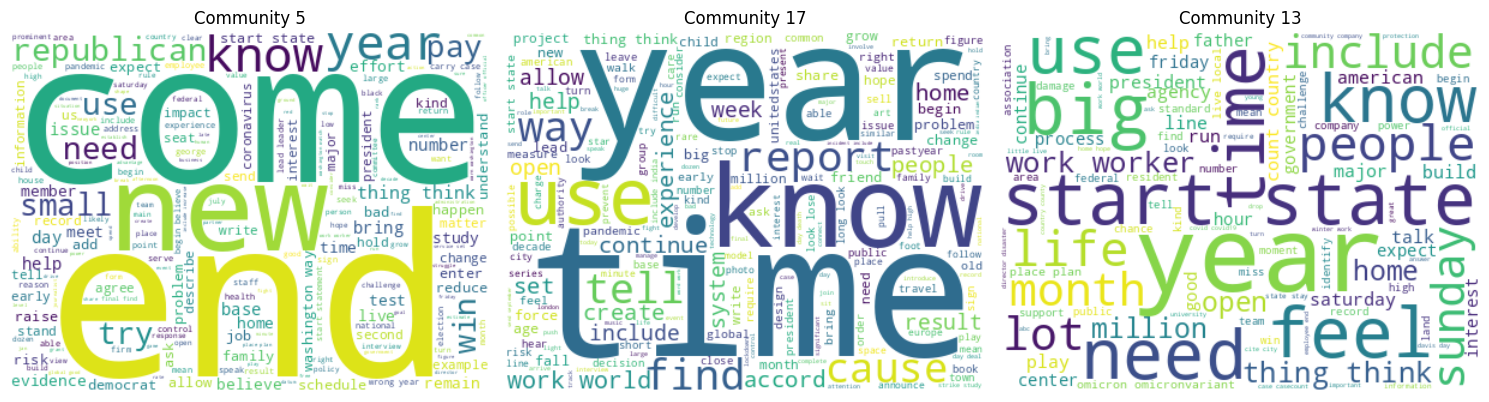


Gephi Visualization Instructions:
1. Open Gephi and import the 'tweet_network.graphml' file.
2. Go to the 'Appearance' panel and select the 'community_id' attribute for node coloring.
3. Choose a layout algorithm (e.g., Force Atlas 2) and adjust its parameters for optimal visualization.
4. Save the visualization as an image file (e.g., PNG).


In [29]:
import networkx as nx
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Export the graph to a GraphML file
nx.write_graphml(graph, "tweet_network.graphml")

# Identify the three largest communities
community_counts = df_ner['community_id'].value_counts()
top_three_communities = community_counts.nlargest(3).index

# Generate word clouds for the top three communities
plt.figure(figsize=(15, 10))
for i, community_id in enumerate(top_three_communities):
    community_tweets = df_ner[df_ner['community_id'] == community_id]
    combined_text = ' '.join(community_tweets['bag_of_phrases'])
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(combined_text)

    plt.subplot(1, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Community {community_id}")

plt.tight_layout()
plt.show()

print("\nGephi Visualization Instructions:")
print("1. Open Gephi and import the 'tweet_network.graphml' file.")
print("2. Go to the 'Appearance' panel and select the 'community_id' attribute for node coloring.")
print("3. Choose a layout algorithm (e.g., Force Atlas 2) and adjust its parameters for optimal visualization.")
print("4. Save the visualization as an image file (e.g., PNG).")

# K-Plex built-in: k_clique_communities() -> detects overlapping cliques (k-clique).

Number of k-plex communities: 4
k-plex community sizes: min=3, max=168, avg=45.00


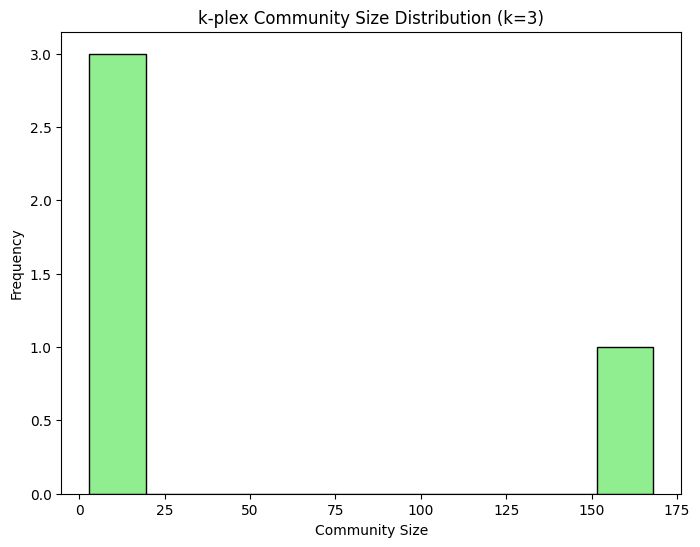

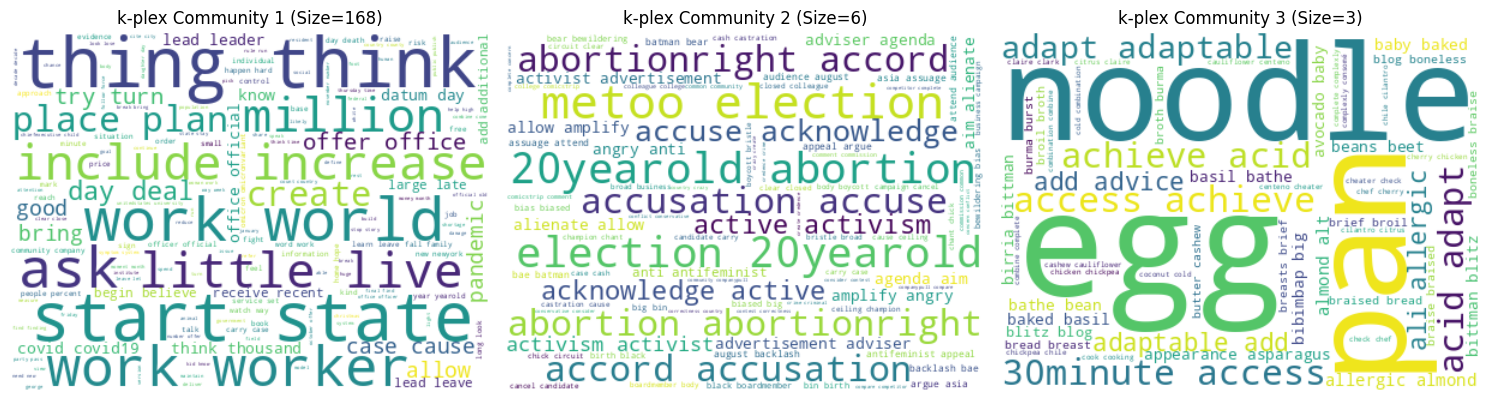

k-plex community overlapping detection completed in 1.94 seconds


In [30]:
### k-plex Community Detection
import networkx as nx
from networkx.algorithms.community import k_clique_communities
import matplotlib.pyplot as plt
from collections import defaultdict

start_time = time()

# Detect k-plex communities (using k-clique as a proxy for k-plex, k=3)
k = 3
k_clique_comms = list(k_clique_communities(graph, k))

# Assign k-plex community IDs to nodes
kplex_community_map = defaultdict(list)
for i, comm in enumerate(k_clique_comms):
    for node in comm:
        kplex_community_map[node].append(i)

# Store k-plex community assignments in df_ner
df_ner['kplex_communities'] = df_ner['id'].apply(lambda x: kplex_community_map.get(x, []))

# Analyze k-plex community sizes
kplex_sizes = [len(comm) for comm in k_clique_comms]
print(f"Number of k-plex communities: {len(k_clique_comms)}")
print(f"k-plex community sizes: min={min(kplex_sizes, default=0)}, max={max(kplex_sizes, default=0)}, avg={sum(kplex_sizes)/len(kplex_sizes) if kplex_sizes else 0:.2f}")

# Visualize k-plex community size distribution
plt.figure(figsize=(8, 6))
plt.hist(kplex_sizes, bins=10, color='lightgreen', edgecolor='black')
plt.title(f'k-plex Community Size Distribution (k={k})')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.show()

# Generate word clouds for top 3 largest k-plex communities
plt.figure(figsize=(15, 10))
for i, comm in enumerate(sorted(k_clique_comms, key=len, reverse=True)[:3]):
    community_tweets = df_ner[df_ner['id'].isin(comm)]
    combined_text = ' '.join(community_tweets['bag_of_phrases'])
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(combined_text)
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"k-plex Community {i+1} (Size={len(comm)})")

plt.tight_layout()
plt.show()

end_time = time()
kplex_community_overlapping_detection_time = end_time - start_time
print(f"k-plex community overlapping detection completed in {kplex_community_overlapping_detection_time:.2f} seconds")

# K-Plex detects relaxed social groups (true k-plex).

Number of k-plex communities: 290
k-plex community sizes: min=1, max=25, avg=5.89


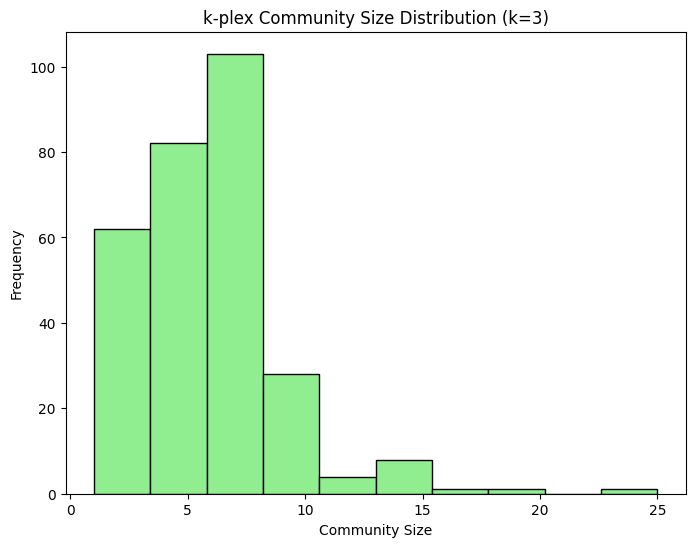

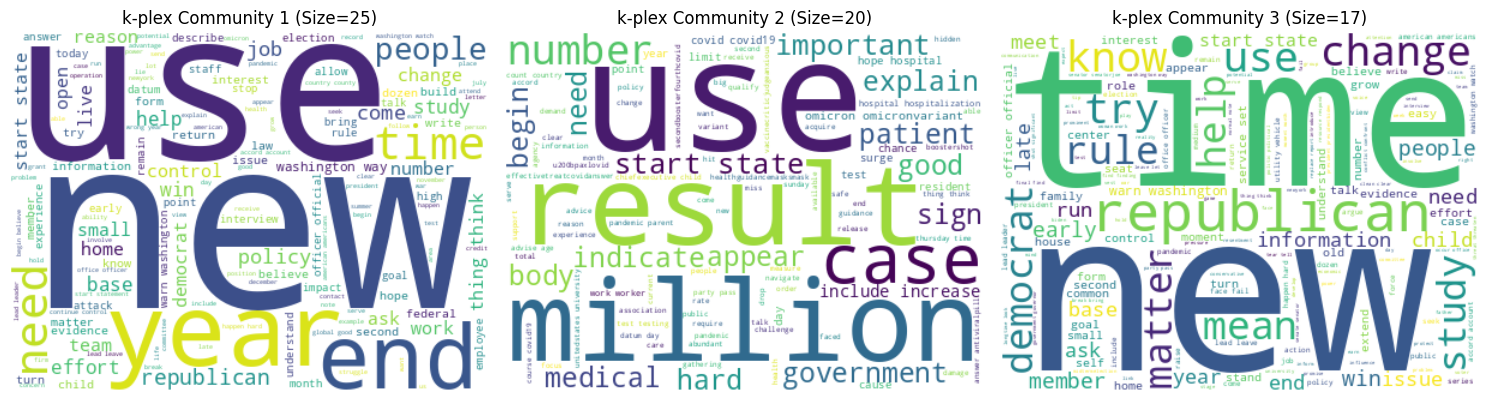

k-plex community detection completed in 2.32 seconds


In [31]:
start_time = time()

def is_k_plex(graph, nodes, k):
    subgraph = graph.subgraph(nodes)
    for node in nodes:
        degree = subgraph.degree(node)
        if degree < len(nodes) - k:
            return False
    return True

def find_k_plexes(graph, k, max_size=None):
    k_plexes = []
    nodes = list(graph.nodes())
    
    def bron_kerbosch(R, P, X, k):
        if not P and not X:
            if is_k_plex(graph, R, k):
                k_plexes.append(set(R))
            return
        pivot = max(P | X, key=lambda u: len(set(graph.neighbors(u)) & (P | X)), default=None)
        if pivot is None:
            return
        for v in P - set(graph.neighbors(pivot)):
            new_R = R | {v}
            new_P = P & set(graph.neighbors(v))
            new_X = X & set(graph.neighbors(v))
            bron_kerbosch(new_R, new_P, new_X, k)
            P.remove(v)
            X.add(v)
    
    bron_kerbosch(set(), set(nodes), set(), k)
    if max_size:
        k_plexes = [plex for plex in k_plexes if len(plex) <= max_size]
    return k_plexes

k = 3
k_plexes = find_k_plexes(graph, k, max_size=50)
kplex_community_map = defaultdict(list)
for i, comm in enumerate(k_plexes):
    for node in comm:
        kplex_community_map[node].append(i)

df_ner['kplex_communities'] = df_ner['id'].apply(lambda x: kplex_community_map.get(x, []))

kplex_sizes = [len(comm) for comm in k_plexes]
print(f"Number of k-plex communities: {len(k_plexes)}")
print(f"k-plex community sizes: min={min(kplex_sizes, default=0)}, max={max(kplex_sizes, default=0)}, avg={sum(kplex_sizes)/len(kplex_sizes) if kplex_sizes else 0:.2f}")

plt.figure(figsize=(8, 6))
plt.hist(kplex_sizes, bins=10, color='lightgreen', edgecolor='black')
plt.title(f'k-plex Community Size Distribution (k={k})')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.savefig('kplex_size_distribution.png')
plt.show()

plt.figure(figsize=(15, 10))
for i, comm in enumerate(sorted(k_plexes, key=len, reverse=True)[:3]):
    community_tweets = df_ner[df_ner['id'].isin(comm)]
    combined_text = ' '.join(community_tweets['bag_of_phrases'])
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(combined_text)
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"k-plex Community {i+1} (Size={len(comm)})")
plt.tight_layout()
plt.savefig('kplex_community_wordclouds.png')
plt.show()

end_time = time()
kplex_community_detection_time = end_time - start_time
print(f"k-plex community detection completed in {kplex_community_detection_time:.2f} seconds")

In [32]:
df_ner.to_csv('dataset_kplex.csv',index=False)

# 7 and 8: Pearson Correlation and Associated p-value
7. Write a script to evaluate the correlation between Retweet_count and Like_count, between Reply_count and Like_count.
8. Write a script to evaluate the correlation between retweent_count and Number of tokens in bag_of_phrases; between Reply_count and Number of tokens in bag_of_phrases; between Like_count and Number of tokens in bag_of_phrases.

In [33]:
from scipy.stats import pearsonr
from time import time

# Start timer
start_time = time()

# Calculate correlations and p-values
retweet_like_correlation, retweet_like_p_value = pearsonr(df_ner['retweet_count'], df_ner['like_count'])
reply_like_correlation, reply_like_p_value = pearsonr(df_ner['reply_count'], df_ner['like_count'])
retweet_token_correlation, retweet_token_p_value = pearsonr(df_ner['retweet_count'], df_ner['token_count'])
reply_token_correlation, reply_token_p_value = pearsonr(df_ner['reply_count'], df_ner['token_count'])
like_token_correlation, like_token_p_value = pearsonr(df_ner['like_count'], df_ner['token_count'])

# Display the results
print(f"{'Correlation':<25} {'P-value':<10}")
print("-" * 35)
print(f"Retweet vs. Like: {retweet_like_correlation:<10.4f} {retweet_like_p_value:<10.4f}")
print(f"Reply vs. Like: {reply_like_correlation:<10.4f} {reply_like_p_value:<10.4f}")
print(f"Retweet vs. Token Count: {retweet_token_correlation:<10.4f} {retweet_token_p_value:<10.4f}")
print(f"Reply vs. Token Count: {reply_token_correlation:<10.4f} {reply_token_p_value:<10.4f}")
print(f"Like vs. Token Count: {like_token_correlation:<10.4f} {like_token_p_value:<10.4f}")

# End timer and report
end_time = time()
print(f"Correlation analysis completed in {end_time - start_time:.2f} seconds")

Correlation               P-value   
-----------------------------------
Retweet vs. Like: 0.9294     0.0000    
Reply vs. Like: 0.9304     0.0000    
Retweet vs. Token Count: -0.0875    0.2250    
Reply vs. Token Count: -0.0728    0.3132    
Like vs. Token Count: -0.1003    0.1641    
Correlation analysis completed in 0.01 seconds


## Highest Degree Erdos

Identify the node with the highest degree ("Erdos") in the graph. Calculate the Erdos numbers for all other nodes in the graph using BFS.


In [34]:
import networkx as nx
from time import time

# Start timer
start_time = time()

# 1. Find the Erdos node (highest degree)
degrees = dict(graph.degree())
erdos_node = max(degrees, key=degrees.get)
print(f"Erdos node: {erdos_node}")

# 2. Calculate Erdos numbers using BFS
erdos_numbers = nx.shortest_path_length(graph, source=erdos_node)

# 3. Store Erdos numbers in df_ner
df_ner['erdos_number'] = df_ner['id'].map(erdos_numbers).fillna(float('inf'))

# 4. Summarize Erdos number distribution
reachable_nodes = df_ner[df_ner['erdos_number'] != float('inf')]
min_erdos = reachable_nodes['erdos_number'].min()
max_erdos = reachable_nodes['erdos_number'].max()
avg_erdos = reachable_nodes['erdos_number'].mean()
unreachable_count = len(df_ner) - len(reachable_nodes)

print(f"Minimum Erdos number: {min_erdos}")
print(f"Maximum Erdos number: {max_erdos}")
print(f"Average Erdos number: {avg_erdos}")
print(f"Number of unreachable nodes: {unreachable_count}")

# End timer and report
end_time = time()
erdos_number_time = end_time - start_time
print(f"Erdos number calculation completed in {erdos_number_time:.2f} seconds")

display(df_ner.head())

Erdos node: 1478113980472344584
Minimum Erdos number: 0.0
Maximum Erdos number: 3.0
Average Erdos number: 1.6416184971098267
Number of unreachable nodes: 21
Erdos number calculation completed in 0.01 seconds


id  retweet_count  reply_count  like_count  \
70   1477571634806591489             67           91         602   
101  1477202997319028738             74           35         537   
126  1477677348959006728             49           29         215   
163  1477760365694005249             96           25         198   
178  1477082218719756293            341           63        2768   

                         url                      date  \
70   https://nyti.ms/3HkK706 2022-01-02 09:25:04+00:00   
101  https://nyti.ms/3pI1T7H 2022-01-01 09:00:14+00:00   
126  https://nyti.ms/3eNqkKo 2022-01-02 16:25:08+00:00   
163  https://nyti.ms/3sQAVwp 2022-01-02 21:55:01+00:00   
178  https://nyti.ms/3sJ5unV 2022-01-01 01:00:18+00:00   

                                        bag_of_phrases  token_count  \
70   1200 15 1908 1960 1980 1990 2013 2020 20year 3...          349   
101  10 20 2021 323 41240 71percent able accord add...          266   
126  1 10 100 12 1976 1980 1990 2 2013 2015 2024 3 ...          300   
163  13 14 2019 25 57 abandon abdalla abdel accord ...          323   
178  n n   nfeature 10inch 20minute 300 425 5minute...           88   

                                              entities  degree_centrality  \
70   [authorstudy, bethisrael bic, boston, bulletin...           0.077720   
101  [berlin, discos, franklin friday, hairdresser ...           0.015544   
126  [congress, delta desert detection director, ji...           0.108808   
163  [abdalla abdel accord, al allow, burhan burn c...           0.036269   
178                                 [melt milk minute]           0.005181   

     betweenness_centrality  closeness_centrality  clustering_coefficient  \
70                 0.002496              0.405516                0.447619   
101                0.000035              0.330356                0.666667   
126                0.001191              0.422273                0.561905   
163                0.000635              0.370254                0.523810   
178                0.000000              0.005181                0.000000   

     community_id                      kplex_communities  erdos_number  
70              2     [8, 9, 10, 11, 12, 13, 14, 15, 16]           2.0  
101             5                               [17, 18]           2.0  
126             5  [90, 91, 92, 121, 135, 145, 281, 282]           1.0  
163             9                                [0, 19]           2.0  
178             3                                   [21]           inf

In [35]:
df_ner.to_csv('dataset_final.csv',index=False)

# 9. Erdos Number Histogram Visualization

Consider the node with the highest degree score playing the role of Erdos in Erdos number network. Write a script that calculates the Erdos number of each other node in the network and save the result in a file. Then draw the distribution of Erdos numbers of the underlined network

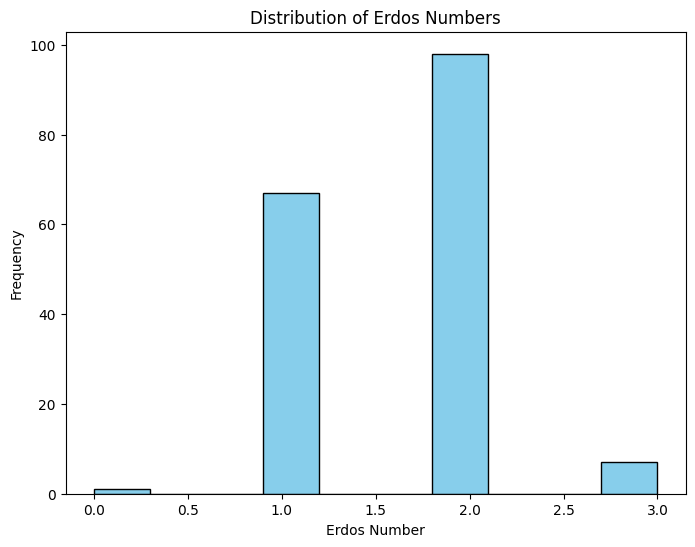

In [36]:
import matplotlib.pyplot as plt

# Create the histogram, excluding infinite Erdos numbers
plt.figure(figsize=(8, 6))
plt.hist(df_ner[df_ner['erdos_number'] != float('inf')]['erdos_number'], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Erdos Number')
plt.ylabel('Frequency')
plt.title('Distribution of Erdos Numbers')

# Display the plot
plt.show()

In [37]:
print(f"'bag_of_phrases' cleaning completed in {end_time - start_time:.2f} seconds")
print(f"NER/Entity extraction completed in {ner_time:.2f} seconds")
print(f"Graph construction completed in {graph_construction_time:.2f} seconds")
print(f"Power-law fitting completed in {power_fit_time:.2f} seconds")
print(f"Graph metrics calculation completed in {graph_metric_time:.2f} seconds")
print(f"k-plex community detection completed in {kplex_community_detection_time:.2f} seconds")
print(f"k-plex community overlapping detection completed in {kplex_community_overlapping_detection_time:.2f} seconds")
print(f"Erdos number calculation completed in {erdos_number_time:.2f} seconds")
print(f"Clustering coefficient calculation completed in {clustering_coefficient_time:.2f} seconds")

'bag_of_phrases' cleaning completed in 0.01 seconds
NER/Entity extraction completed in 11.60 seconds
Graph construction completed in 3.00 seconds
Power-law fitting completed in 1.47 seconds
Graph metrics calculation completed in 0.41 seconds
k-plex community detection completed in 2.32 seconds
k-plex community overlapping detection completed in 1.94 seconds
Erdos number calculation completed in 0.01 seconds
Clustering coefficient calculation completed in 0.03 seconds
